In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def trata_producto_names(df_producto):
    from nltk.stem.snowball import SnowballStemmer

    df_producto['short_names'] = df_producto.NombreProducto.str.extract('^(\D*)')
    df_producto['short_names_processed'] = df_producto['short_names'].map(lambda x: " ".join([i for i in x.lower().split() if i not in stopwords.words('spanish')]))

    stemmer = SnowballStemmer("spanish")

    df_producto['short_names_processed'] = (df_producto['short_names_processed']
                                            .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))
    df_aux_producto = df_producto['short_names_processed'].value_counts()[df_producto['short_names_processed'].value_counts() > 10].reset_index()

    df_producto['flavor_choc'] = df_producto.short_names_processed.str.contains('choc') * 1
    df_producto['flavor_vainill'] = df_producto.short_names_processed.str.contains('vainill') * 1
    df_producto['flavor_canel'] = df_producto.short_names_processed.str.contains('canel') * 1

    df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
    df_producto = pd.DataFrame(df_producto.loc[1:])
    df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
    df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

    reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
    df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

    reg = '(\d{1,5}P)'
    df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
    df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

    aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
    df_producto = df_producto.append(aux)

    df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
    df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')
    df_producto['product_name_length'] = df_producto.NombreProducto.str.split(' ').str.len()
    return df_producto

In [3]:
def count_cliente_by_route():
    l = []
    for i in range(3,10):
        df_week = pd.read_csv('input/train_week%s.csv' % i, usecols=['Cliente_ID','Ruta_SAK'])
        count_cliente = df_week.merge(df_cliente, on='Cliente_ID', how='left')
        count_cliente.ix[(count_cliente.NombreCliente != 'SIN NOMBRE'), 'NombreCliente'] = 'NO IDENTIFICADO'
        count_cliente = df_week.merge(df_cliente, on='Cliente_ID', how='left')
        count_cliente.ix[(count_cliente.NombreCliente != 'SIN NOMBRE'), 'NombreCliente'] = 'NO IDENTIFICADO'
        count_cliente = count_cliente[['Ruta_SAK','NombreCliente']].groupby(['Ruta_SAK']).count().reset_index()
        l.append(count_cliente)
    result = pd.concat(l)
    result = result.groupby('Ruta_SAK').mean().reset_index()
    result.columns = ['Ruta_SAK','count_clientes']
    return result

In [4]:
def process_venta_producto():
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Producto_ID','Venta_hoy'])
        prod_venta = df_week[['Producto_ID','Venta_hoy']].groupby('Producto_ID').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta.groupby('Producto_ID').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log10(df_venta['Venta_hoy'].values + 1))
    return df_venta

In [5]:
def process_venta_agencia(df_townstate):
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Agencia_ID','Venta_hoy'])
        aux = df_week.merge(df_townstate, how='left', on='Agencia_ID')
        prod_venta = aux.groupby('State').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta[['Agencia_ID','Venta_hoy','State']].groupby('State').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log(df_venta['Venta_hoy'].values+1))
    return df_venta

In [6]:
def process_producto():
    df_producto = pd.read_csv('input/producto_tabla.csv.gz', compression='gzip')
    df_producto = trata_producto_names(df_producto)
    return df_producto

In [7]:
def process_df(df, test=False):    
    if not test:
        df = df.ix[df.Demanda_uni_equil<15]   
    
    df = df.merge(df_retorno_cliente, on='Cliente_ID', how='left') 
    df = df.merge(df_retorno_produto, on='Producto_ID', how='left') 
    df = df.merge(df_retorno_agencia, on='Agencia_ID', how='left')
    
#     df = df.merge(df_agencia_canal, on='Canal_ID', how='left')
#     df = df.merge(df_agencia_produto, on='Agencia_ID', how='left')
#     df = df.merge(df_cliente_canal, on='Canal_ID', how='left')
    
    
    df = df.merge(df_media_unidades, on=['Cliente_ID','Producto_ID'], how='left')
#     df = df.merge(df_media_clientes_depot, on='Agencia_ID', how='left')
    df = df.merge(df_popularidade_produto, on='Producto_ID', how='left')
    df = df.merge(df_produto_preco_medio, on='Producto_ID', how='left')
    df = df.merge(df_clientes_ruta, on='Ruta_SAK', how='left')
        
    df = df.merge(df_producto[['flavor_choc', 'flavor_vainill', 'flavor_canel','volume', 'fabricante','Producto_ID', 'product_name_length']], how='left',on='Producto_ID')
    df = df.merge(df_townstate[['Agencia_ID','ag','bimbo']], on='Agencia_ID', how='left')
    
    df.volume = df.volume.fillna(-9999).astype('int')

    df.ix[df.volume>500,'volume'] = 9999
        
    
    df['Canal_ID'] = (df['Canal_ID'] == 1) *1
        
    return df

In [8]:
def compras_cliente_mean():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Cliente_ID','Producto_ID','Venta_uni_hoy'])
        l.append(df.groupby(['Cliente_ID','Producto_ID']).mean().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Cliente_ID','Producto_ID']).mean().reset_index()
    df.columns = ['Cliente_ID','Producto_ID','media_de_unidades']
    df['media_de_unidades_log'] = np.log(df['media_de_unidades'].values+1)
    df['media_de_unidades_sqrt'] = np.sqrt(df['media_de_unidades'].values)    
    return df

In [10]:
def produto_popularidade():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Producto_ID','Venta_uni_hoy'])
        l.append(df.groupby(['Producto_ID']).sum().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Producto_ID']).mean().reset_index()
    df.columns = ['Producto_ID','produto_popularidade']
    df['produto_popularidade_log'] = np.log(df['produto_popularidade'].values+1)
    df['produto_popularidade_sqrt'] = np.sqrt(df['produto_popularidade'].values)
    return df

In [11]:
def produto_preco_mean():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Producto_ID','Venta_uni_hoy','Venta_hoy'])
        df['preco_medio'] = df['Venta_hoy'] / df['Venta_uni_hoy']
        l.append(df.groupby(['Producto_ID']).mean().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Producto_ID']).mean().reset_index()
    df[['Producto_ID','preco_medio']].columns = ['Producto_ID','preco_medio']
    df['preco_medio'] = df['preco_medio'].fillna(0)
    df['preco_medio_log'] = np.log(df['preco_medio'].values+1)
    df['preco_medio_sqrt'] = np.sqrt(df['preco_medio'].values)
    return df[['Producto_ID','preco_medio','preco_medio_log','preco_medio_sqrt']]

In [12]:
def count_clientes_ruta():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Ruta_SAK','Cliente_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Ruta_SAK']).count().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Ruta_SAK']).mean().reset_index()
    df.columns = ['Ruta_SAK','clientes_por_rota']
    df['clientes_por_rota_log'] = np.log(df['clientes_por_rota'].values+1)
    df['clientes_por_rota_sqrt'] = np.sqrt(df['clientes_por_rota'].values)
    return df

In [13]:
df_media_unidades = compras_cliente_mean()
df_popularidade_produto = produto_popularidade()
df_produto_preco_medio = produto_preco_mean()
df_clientes_ruta = count_clientes_ruta()

In [14]:
def retorno_por_agencia():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Dev_uni_proxima','Agencia_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Agencia_ID']).sum().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Agencia_ID']).mean().reset_index()
    df.columns = ['Agencia_ID','devolucao_por_agencia']
    df['devolucao_por_agencia_log'] = np.log(df['devolucao_por_agencia'].values+1)
    df['devolucao_por_agencia_sqrt'] = np.sqrt(df['devolucao_por_agencia'].values)
    return df

In [15]:
df_retorno_agencia = retorno_por_agencia()

In [16]:
def retorno_por_cliente():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Dev_uni_proxima','Cliente_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Cliente_ID']).sum().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Cliente_ID']).mean().reset_index()
    df.columns = ['Cliente_ID','devolucao_por_cliente']
    df['devolucao_por_cliente_log'] = np.log(df['devolucao_por_cliente'].values+1)
    df['devolucao_por_cliente_sqrt'] = np.sqrt(df['devolucao_por_cliente'].values)
    return df

In [17]:
df_retorno_cliente = retorno_por_cliente()

In [18]:
def retorno_por_produto():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Dev_uni_proxima','Producto_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Producto_ID']).sum().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Producto_ID']).mean().reset_index()
    df.columns = ['Producto_ID','devolucao_por_produto']
    df['devolucao_por_produto_log'] = np.log(df['devolucao_por_produto'].values+1)
    df['devolucao_por_produto_sqrt'] = np.sqrt(df['devolucao_por_produto'].values)
    return df

In [19]:
df_retorno_produto = retorno_por_produto()

In [20]:
from nltk.corpus import stopwords

In [21]:
stop_words = stopwords.words('spanish')

In [22]:
df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')
df_townstate['bimbo'] = df_townstate.Town.str.contains('BIMBO') * 1
df_townstate['ag'] = df_townstate.Town.str.contains('AG.') * 1

In [23]:
pd.options.display.max_rows = 30

In [24]:
df_producto = process_producto()

In [25]:
# df_process['fabricante'].value_counts()

In [75]:
cols = [    
    'media_de_unidades_log',
#     'produto_popularidade_log',
#     'preco_medio_log',
#     'clientes_por_rota_log',
    
    
#     'devolucao_por_cliente_log',
#     'devolucao_por_produto_log',
#     'volume',
#     'product_name_length',
]

In [27]:
# aux.Agencia_ID.dtype 

In [28]:
# enc._n_values

# fiitting model

In [38]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [30]:
def rmsle_func(truths, preds):
    truths = np.asarray(truths)
    preds = np.asarray(preds)
    
    n = len(truths)
    diff = (np.log(preds+1) - np.log(truths+1))**2
#     print(diff, n, np.sum(diff))
    return np.sqrt(np.sum(diff)/n)

In [31]:
# rf = ExtraTreesRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)



def train(x, y):
    results = []
    kf = StratifiedKFold(y, n_folds=3, random_state=401)
    for (train, test) in kf:
        rf.fit(x[train], y[train])
        y_pred = rf.predict(x[test])
        result = rmsle_func(y[test], y_pred)
#         print("RESULT", result)
        results.append(result)
        print(len(results), end='\r')
    return results
        

In [32]:
# df.columns

In [77]:
rf = RandomForestRegressor(
    random_state=401, n_jobs=4,
                          )

for week in range(3,10):
#     week = 9
    print('fitting week %s... ' % week,)
#     df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Demanda_uni_equil','Cliente_ID','Agencia_ID','Producto_ID','Ruta_SAK','Canal_ID'])
    for df_week in pd.read_csv('input/train_week%s.csv' % week, 
                               usecols=['Demanda_uni_equil','Cliente_ID','Agencia_ID','Producto_ID','Ruta_SAK','Canal_ID'], chunksize=10000):
        aux = process_df(df_week)
        df = aux[cols+['Demanda_uni_equil']]
        df = pd.get_dummies(df)

        df_partial = df
        x = df_partial.drop(['Demanda_uni_equil'], axis=1).values
        y = df_partial['Demanda_uni_equil'].values
        results = train(x,y)
#         del df_week, aux, x, y, df_partial
        print('mean result:',np.mean(results), 'std:',np.std(results))
#         print(' ')
        break
    break


fitting week 3... 
mean result: 0.34531014222 std: 0.0145909201955


# Principal component analysis

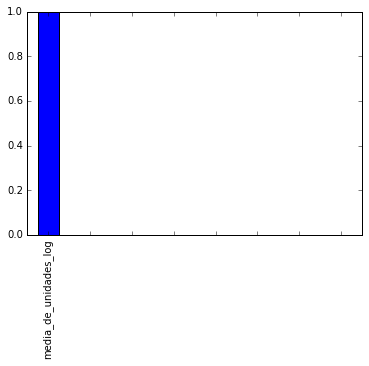

In [76]:
pca = PCA()
pca.fit(x)
# pca.explained_variance_ratio_.shape
ax = pd.Series(pca.explained_variance_ratio_).plot(kind='bar')
ax.set_xticklabels(cols)

8

<Container object of 8 artists>

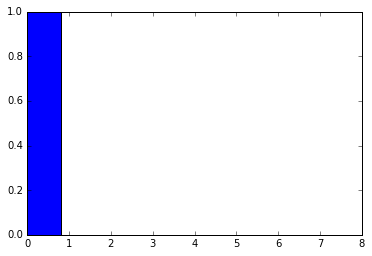

In [ ]:
import pickle

In [35]:
# f = open('randomforest.pkl', 'wb')
# pickle.dump(rf, f)
# f.close()

In [ ]:
# f = open('randomforest.pkl', 'rb')
# rf = pickle.load(f)
# f.close()

In [ ]:
# benchmark GB => 5.94199629697, 10000
# benchmark RF => 0.35103308505, 10000
# benchmark Linear => 6.30695175461, 10000
# benchmark AdaBoost => 6.09610259777, 10000
 

# Validating model

In [34]:
def prediction(df, test=True):
    aux = process_df(df, test)    
    df = aux[cols]
    df = pd.get_dummies(df)
    df_partial = df.fillna(0)
    x = df_partial.values
    y_pred = rf.predict(x)
    return y_pred

In [35]:
df_validation = pd.read_csv('input/train_week9.csv')

In [36]:
y_pred = prediction(df_validation, True)

In [37]:
y = df_validation['Demanda_uni_equil'].values
result = rmsle_func(y, y_pred)
print(result)

0.522055830059


# testing feature importances

In [74]:
a = pd.DataFrame([{'a':0},{'a':1},{'a':2},{'a':4}])
b = pd.DataFrame([{'a':0, 'b':5},{'a':1, 'b':6},{'a':2, 'b':7},{'a':3, 'b':8},{'a':4, 'b':9}])

,a,b
0,0,5
1,1,6
2,2,7
3,4,9


In [55]:
a = df

In [56]:
rf.feature_importances_.shape

(8,)

In [57]:
# a.columns

In [58]:
a.columns[:]

Index(['media_de_unidades_log', 'produto_popularidade_log', 'preco_medio_log',
       'clientes_por_rota_log', 'devolucao_por_cliente_log',
       'devolucao_por_produto_log', 'volume', 'product_name_length',
       'Demanda_uni_equil'],
      dtype='object')

<Container object of 8 artists>

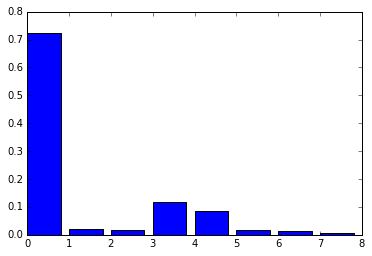

In [59]:
plt.bar(range(0,8), height=rf.feature_importances_)

In [ ]:
# aux.Demanda_uni_equil.value_counts().plot(kind='bar')

In [ ]:
aux.columns

# test prediction

In [ ]:
df_test.index

In [36]:
df_test = pd.read_csv('input/test.csv.gz')

In [39]:
ypred = prediction(df_test, True)

In [40]:
result = pd.DataFrame(ypred, columns=['Demanda_uni_equil'])

In [41]:
result['id'] = result.index

In [42]:
from datetime import datetime
d = datetime.now()
d = d.strftime('%Y%m%d%M')
result[['id','Demanda_uni_equil']].to_csv('result_%s.csv.gz'%d, compression='gzip', index=False)

'2016071425'

In [ ]:
pd.read_csv('input/sample_submission.csv.gz', compression='gzip')

In [ ]:
df_test = pd.read_csv('input/test.csv.gz', compression='gzip')

In [ ]:
df = process_df(df_test, test=True)
# df = aux.iloc[np.random.permutation(len(aux))]
df = pd.get_dummies(df)
res = rf.predict(df.values)

In [ ]:
a = df_test.merge(df_producto, how='left', on='Producto_ID')

In [ ]:
a.Venta_uni_hoy.hist(range=(0,10), bins=2)

In [ ]:
# df_process['short_names_processed']

In [ ]:
# pd.get_dummies(df_process[0:100][cols])

In [ ]:
f = plt.subplots()
i = 444
for v in x.T:
    i+=1
    f.hist(v)

In [ ]:
df.columns

In [ ]:
count_entregas(df, 'Agencia_ID')